In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 
from tqdm import trange

from celluloid import Camera
from IPython.display import HTML, Image

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
plt.rcParams['animation.ffmpeg_path'] = r'C:\ffmpeg\ffmpeg\bin\ffmpeg.exe'
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

In [4]:
def generate_forest(size, probability):
    """
    Generates a model of forest as a matrix, where: 
        empty cell is represented by 0
        occupied by a tree is represented by 1
        burning tree is represented by 2
        
    Input:
        size: int - length of one side in square lattice
        probability: float - probability, in which a cell is populated by a tree
        
    Output:
        matrix: numpy.array - model of forest as numpy matrix
    """
    matrix = np.random.rand(size*size)
    matrix = np.where(matrix > probability, 0, 1)
    matrix = np.reshape(matrix, (size, size))
    matrix[-1, :] = np.where(matrix[-1, :] == 1, 2, 0)
    
    return matrix

In [5]:
def get_neighbours(matrix, x, y):
    """
    Finds neighbours of a given cell
    
    Input:
        matrix: numpy.array - model of forest as numpy matrix
        x: int - number of row for a given cell
        y: int - number of column for a given cell
        
    Output:
        neighbours: list - list of states of neighbours
    """
    new_array = np.zeros(shape=(len(matrix)+2, len(matrix)+2), dtype=int)
    new_array[1:-1, 1:-1] = matrix  
    
    neighbours = []
    standard_neighbours = ((-1,-1), (-1,0), (-1,1), (0,-1), (0, 1), (1,-1), (1,0), (1,1))
    for dx, dy in standard_neighbours:
        neighbours.append(new_array[x+1+dx][y+1+dy])
    
    return neighbours

In [6]:
def fire_simulation(matrix):
    """
    Simulation of burning forest. Rules: A cell occupied by a tree becomes a burning cell, if any of its eight 
    neighboring cells are burning. A burning cell turns into an burnt tree and it is represented by 3 in matrix. 
    
    Input:
        matrix: numpy.array - model of forest as numpy matrix
        
    Output:
        states: list - list of numpy.array objects representing all steps of burning forest
    """
    states = [matrix]
    next_step = np.array(matrix, copy=True)
    hit_opposite_edge = False
    while np.any(matrix[:, :] == 2):  # until there is at least one burning cell
        if np.any(matrix[0, :] == 2):  # top row has burning cell
            hit_opposite_edge = True
        for i in range(L):
            for j in range(L):
                neighbours = get_neighbours(matrix, i, j)
                if matrix[i, j] == 2:  # burning cell turns into burnt tree
                    next_step[i, j] = 3
                elif 2 in neighbours and matrix[i, j] == 1:  # cell has neighbour, which is burning
                    next_step[i, j] = 2

        matrix = np.array(next_step, copy=True) 
        states.append(matrix)
        
    return states, hit_opposite_edge

In [7]:
def show_images(states):
    """
    Shows every step of burning forest
    Input:
        states: list - list of numpy.array objects representing all steps of burning forest
    """
    cmap = ListedColormap(['white', 'green', 'red', 'black'])
    plt.imshow(states[0], interpolation="nearest", cmap=ListedColormap(['white', 'green', 'red']))
    plt.show()
    for i in range(len(states)-1):
        plt.imshow(states[i+1], interpolation="nearest", cmap=cmap)
        plt.show()

In [8]:
def create_frames(states):
    """
    Creates animation from every step of burning forest
    Input:
        states: list - list of numpy.array objects representing all steps of burning forest
    Output:
        animation: plt.animation - captured images to generate a gif file
    """
    cmap = ListedColormap(['white', 'green', 'red', 'black'])
    images = []
    
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = fig.gca()
    camera = Camera(fig)
    
    plt.imshow(states[0], interpolation="nearest", cmap=ListedColormap(['white', 'green', 'red']))
    ax.text(0.40, 1.01, "step 1", size=20, transform=ax.transAxes)
    camera.snap()
    for i in range(len(states)-1):
        ax.text(0.40, 1.01, "step %s" % str(i+1), size=20, transform=ax.transAxes)
        plt.imshow(states[i+1], interpolation="nearest", cmap=cmap)          
        camera.snap()
    
    animation = camera.animate()
    
    return animation 

In [9]:
def percolation_threshold(L, ps, mc):
    """
    Calculates probabilities of hitting the opposite edge by burning cell for different probabilities of populating a tree
    
    Input:
        L: int - length of one side in square lattice
        ps: list - list of probabilities of populating a tree
        mc: int - number of Monte Carlo simulations
        
    Output:
        probabilities: list - list of percolation threshold for different probabilities
        x_threshold: float - percolation threshold coordinate x of p*
        y_threshold: float - percolation threshold coordinate y of p*
    """
    probabilities = []
    for i in trange(len(ps)):
        probability = 0
        for j in range(mc):
            matrix = generate_forest(L, ps[i])
            _, hit_opposite_edge = fire_simulation(matrix)
            if hit_opposite_edge == True:
                probability += 1
        probabilities.append(probability/100)
        
    x_threshold, y_threshold = calculate_percolation_threshold(probabilities, ps)
    
    return probabilities, x_threshold, y_threshold

In [10]:
def calculate_percolation_threshold(probabilities, ps):
    """
    Calculates coordiantes of (x, y) of percolation point
    
    Input:
        probabilities: list - list of percolation threshold for different probabilities
        ps: list - list of probabilities of populating a tree
        
    Output:
        x_threshold: float - percolation threshold coordinate x of p*
        y_threshold: float - percolation threshold coordinate y of p*
    """
    increments = list(np.diff(probabilities))
    max_increment = max(increments)
    increments_index = increments.index(max_increment)
    
    x_threshold = ps[increments_index]/2 + ps[increments_index+1]/2
    y_threshold = probabilities[increments_index]/2 + probabilities[increments_index+1]/2
    
    return x_threshold, y_threshold
    

In [11]:
def plot_percolation_threshold(probabilities, ps, x_threshold, y_threshold):
    """
    Plots all values of probability that fire hit opposite edge and percolation threshold p*
    
    Input:
        probabilities: list - list of percolation threshold for different probabilities
        ps: list - list of probabilities of populating a tree
        x_threshold: float - percolation threshold coordinate x of p*
        y_threshold: float - percolation threshold coordinate y of p*    
    """
    plt.figure(figsize=(16, 9))
    plt.plot(ps, probabilities, '.', markersize=20, label='probability')
    plt.plot(x_threshold, y_threshold, '*', markersize=20, label='percolation threshold')
    plt.xlabel('Probability of planting trees', fontsize=20)
    plt.ylabel('Probability of hitting an opposite edge', fontsize=20)
    plt.title('Distribution of percolation threshold p* = %s for L = %s'% (round(x_threshold, 2), L), fontsize=24)
    plt.legend(prop = {'size': 24})
    plt.grid()

In [12]:
def hk_find(x, label_list):
    """
    
    """
    y = x
    label_list = label_list
    while label_list[y] != y:
        y = label_list[y]
    while label_list[x] != x:
        z = label_list[x]
        label_list[x] = y
        x = z
    return y, label_list

In [13]:
def hk_union(x, y, label_list):
    label_list[hk_find(x, label_list)[0]] = hk_find(y, label_list)[0]
    return label_list

In [14]:
def hk_forest_clustering(matrix, plots=False):
    burnt_trees = np.where(matrix == 3, 1, 0)
    largest_label = 0
    label = np.zeros(matrix.shape, dtype=int)
    label_list = [i for i in range(L*L)]
    for i in range(L):
        for j in range(L):
            if burnt_trees[i,j]:
                left = label[i,j-1] if j-1 >= 0 else 0
                above = label[i-1,j] if i-1 >= 0 else 0
                if left == 0 and above == 0:
                    largest_label += 1
                    label[i,j] = largest_label
                elif left != 0 and above == 0:
                    label[i,j], label_list = hk_find(left, label_list)
                elif left == 0 and above != 0:
                    label[i,j], label_list = hk_find(above, label_list)
                else:
                    label_list = hk_union(left, above, label_list)
                    label[i,j], label_list = hk_find(left, label_list)

    clustered_forest = np.zeros(matrix.shape, dtype=int)
    for i in range(L):
        for j in range(L):
            current_label = label[i,j]
            while current_label != label_list[current_label]:
                current_label = label_list[current_label]
            clustered_forest[i,j] = label_list[current_label]
    
    if plots:       
        plt.figure(figsize=(16,16))
        plt.subplot(2,2,1)
        plt.imshow(matrix, interpolation="nearest", cmap=ListedColormap(['white', 'green', 'black']))
        plt.subplot(2,2,2)
        plt.imshow(np.where(matrix == 3, 1, 0), interpolation="nearest", cmap=ListedColormap(['white', 'black']))
        plt.subplot(2,2,3)
        plt.imshow(label, interpolation="nearest")
        plt.subplot(2,2,4)
        plt.imshow(clustered_forest, interpolation="nearest")
        
    return clustered_forest

In [15]:
def hk_biggest_cluster_size(matrix, plot=False):
    size_counts = np.bincount(matrix.flat[:])[1:]
    biggest_cluster_label = np.bincount(matrix.flat[:])[1:].argmax()
    biggest_cluster_size = size_counts[biggest_cluster_label]
    
    if plot:
        plt.figure(figsize=(8,8))
        plt.imshow((np.where(matrix == biggest_cluster_label+1, 1, 0) + np.where(matrix > 0, 1, 0)),
                   interpolation="nearest", cmap=ListedColormap(['white', 'grey', 'blue']))
    
    return biggest_cluster_size

## Visualisation of spreading of fire

In [16]:
L = 10
p = 0.45

In [17]:
matrix = generate_forest(L, p)

In [18]:
states, hit_opposite_edge = fire_simulation(matrix)

In [19]:
animation = create_frames(states)
animation.save('burning_forest.gif')
plt.close()

In [20]:
HTML(animation.to_html5_video())

## Calculation of percolation thresholds p*

In [21]:
L = 20
ps = np.linspace(0, 1, 51)
mc = 100

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [08:20<00:00,  9.82s/it]


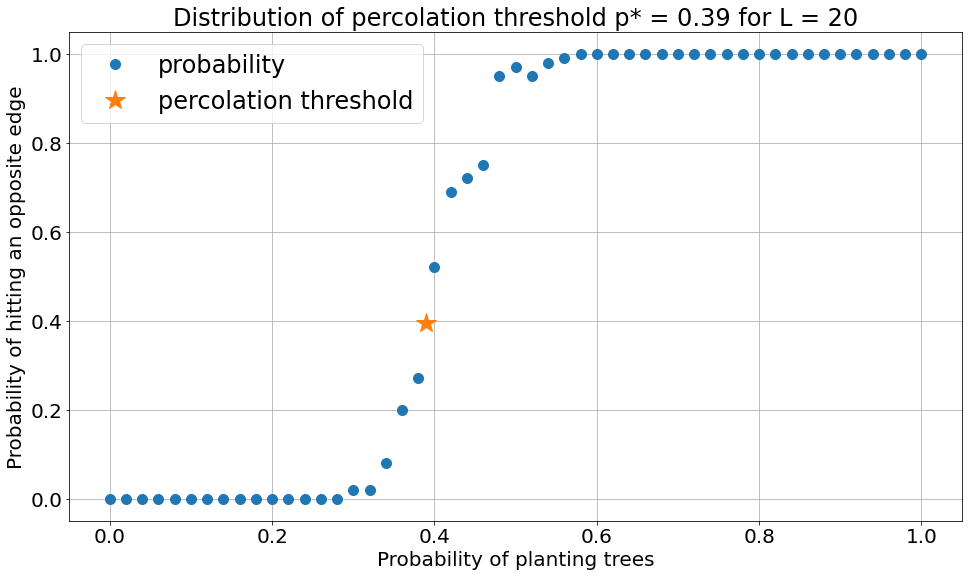

In [22]:
probabilities_L_20, x_threshold, y_threshold = percolation_threshold(L, ps, mc)
plot_percolation_threshold(probabilities_L_20, ps, x_threshold, y_threshold)

## Clustering

In [23]:
L = 50
p = 0.5

matrix = generate_forest(L, p)
states, hit_opposite_edge = fire_simulation(matrix)

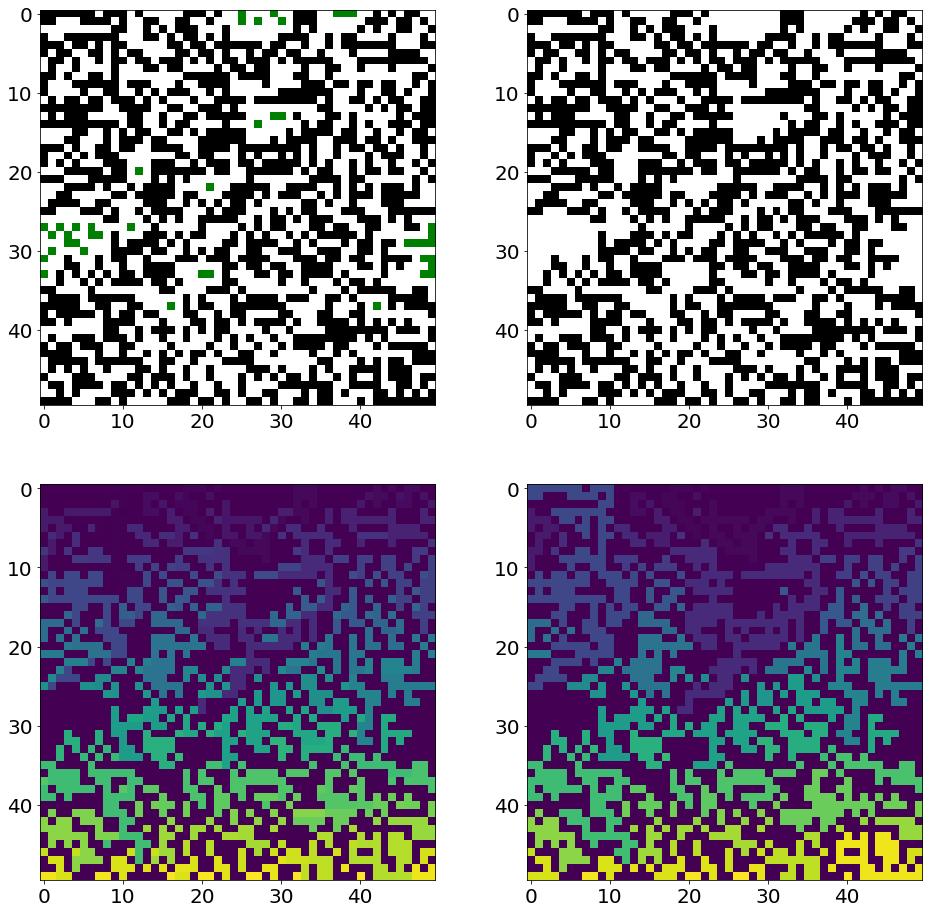

In [24]:
clusters = hk_forest_clustering(states[-1],True)

152

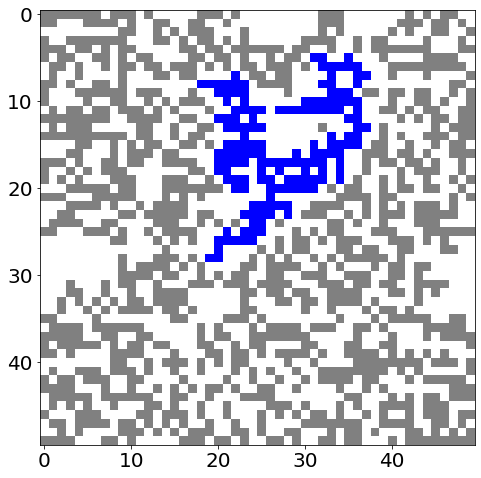

In [25]:
hk_biggest_cluster_size(clusters,True)